## COBIFY - Best Fuel

- Let's import the libraries we'll use and the csv file with the data.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

In [3]:
consume_data = pd.read_csv('/home/julian/Cursos/Ironhack/Career/reto_data/consume_data.csv')

### Exploratory Data Analysis

In [4]:
consume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   consume_id    376 non-null    int64  
 1   distance      376 non-null    float64
 2   consume       376 non-null    float64
 3   speed         376 non-null    int64  
 4   temp_inside   376 non-null    float64
 5   temp_outside  376 non-null    int64  
 6   gas_type      376 non-null    object 
 7   AC            376 non-null    int64  
 8   rain          376 non-null    int64  
 9   sun           376 non-null    int64  
 10  snow          376 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 32.4+ KB


In [5]:
consume_data.isna().value_counts()

consume_id  distance  consume  speed  temp_inside  temp_outside  gas_type  AC     rain   sun    snow 
False       False     False    False  False        False         False     False  False  False  False    376
dtype: int64

In [6]:
consume_data.gas_type.value_counts()

SP98    219
E10     157
Name: gas_type, dtype: int64

- We can see that all variabels are numerical, except for gas_type, which we'll transform into a dummy variable. On the other hand, we don't have null values.
- We'll also drop consume_id column as is an index column.
- 58% of cars use SP98 gas.

In [7]:
consume_data = pd.get_dummies(consume_data, columns=['gas_type'], drop_first=True)

In [8]:
consume_data.drop(columns=['consume_id'], inplace=True)

In [9]:
consume_data.head(3)

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_SP98
0,28.0,5.0,26,21.5,12,0,0,0,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0,0


In [10]:
consume = {'Minimum': consume_data.consume.min(),
          'Maximum': consume_data.consume.max(),
          'Mean': consume_data.consume.mean(),
          'Median': consume_data.consume.median(),
          'Mode': consume_data.consume.mode()}
consume_descr = pd.DataFrame(consume) 
consume_descr = consume_descr.rename(index={0:'Consume'})
consume_descr

,Minimum,Maximum,Mean,Median,Mode
Consume,3.3,12.2,4.925266,4.7,4.5


<AxesSubplot:xlabel='consume', ylabel='Count'>

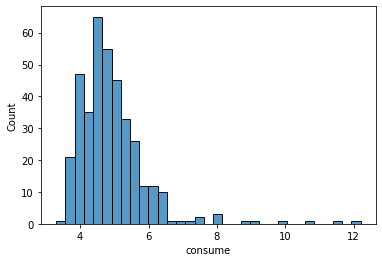

In [11]:
sns.histplot(x='consume', data=consume_data)

<AxesSubplot:xlabel='consume'>

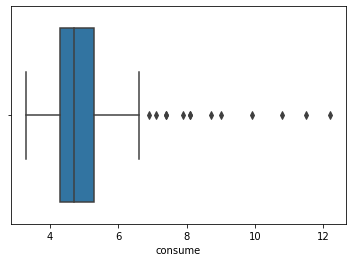

In [12]:
sns.boxplot(x=consume_data.consume)

- From the histogram and boxplot, we can observe that consume variable has some outliers, which we'll have to take into account when doing the regression analysis

In [13]:
corr_matrix = consume_data.corr()

In [14]:
corr_matrix

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_SP98
distance,1.000000,-0.131379,0.565505,0.075305,0.086774,0.019030,-0.030784,0.078627,-0.034428,-0.047877
consume,-0.131379,1.000000,-0.234537,-0.161991,-0.318758,0.089472,0.251756,-0.169173,0.072308,-0.020928
speed,0.565505,-0.234537,1.000000,0.059725,0.019327,-0.024485,-0.004173,0.077181,0.032500,-0.099495
temp_inside,0.075305,-0.161991,0.059725,1.000000,0.361308,0.313197,-0.038269,0.246120,0.097156,0.010340
temp_outside,0.086774,-0.318758,0.019327,0.361308,1.000000,0.180096,-0.184763,0.349988,-0.162948,0.156990
AC,0.019030,0.089472,-0.024485,0.313197,0.180096,1.000000,0.242197,0.085928,0.063170,0.096943
rain,-0.030784,0.251756,-0.004173,-0.038269,-0.184763,0.242197,1.000000,-0.111916,0.277739,0.052789
sun,0.078627,-0.169173,0.077181,0.246120,0.349988,0.085928,-0.111916,1.000000,-0.031083,0.038120
snow,-0.034428,0.072308,0.032500,0.097156,-0.162948,0.063170,0.277739,-0.031083,1.000000,0.035231
gas_type_SP98,-0.047877,-0.020928,-0.099495,0.010340,0.156990,0.096943,0.052789,0.038120,0.035231,1.000000


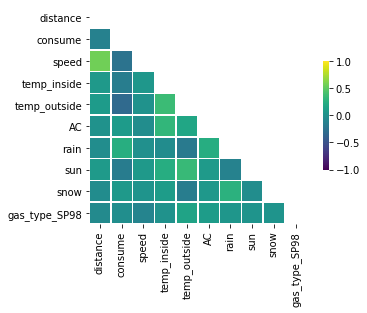

In [15]:
mascara = np.triu(np.ones_like(corr_matrix, dtype=bool))
color_map = sns.diverging_palette(0, 10, as_cmap=True) 

sns.heatmap(corr_matrix, 
            mask=mascara,
            cmap="viridis",
            vmax=1,
            vmin=-1,
            square=True, 
            linewidth=.5, 
            cbar_kws={"shrink": .5} 
);

- We can see through the correlations heatmap that `consume` is mostly correlated with `temp_outside` (negatively), `rain` (positively), `speed` (negatively), `sun` (negatively), and `temp_inside` (negatively).
- We can also observe that `speed` and `distance` are correlated, and `temp_inside` wit `AC`. Both are not surprise.
- Next we'll plot some of these variables against the consume.

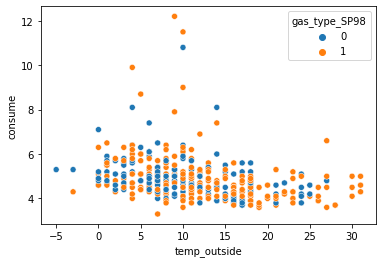

In [16]:
sns.scatterplot(x=consume_data.temp_outside, y=consume_data.consume, hue=consume_data.gas_type_SP98);

- We can see how lower outside temperatures accounts for higher consumption levels. 

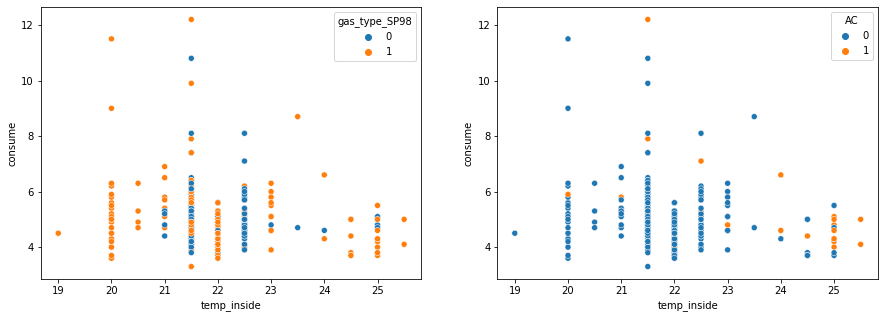

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.scatterplot(data=consume_data, x="temp_inside", y="consume", hue="gas_type_SP98", ax=axs[0])
sns.scatterplot(data=consume_data, x="temp_inside", y="consume", hue="AC", ax=axs[1]);

- We can see that for lower inside temperature values, there are higher consumption values. On the other hand, we can see that most of the cars had the AC off, but those with the AC on, accounts for higher consumption values

In [36]:
gtype_gr = consume_data.groupby('gas_type_SP98').agg({'consume': 'mean'})
gtype_gr

,consume
gas_type_SP98,
0,4.950955
1,4.906849


In [19]:
ac_group = consume_data.groupby('AC').agg({'consume': 'mean'})
ac_group

,consume
AC,
0,4.897391
1,5.235484


In [20]:
rain_gr = consume_data.groupby('rain').agg({'consume': 'mean'})
rain_gr

,consume
rain,
0,4.827576
1,5.626087


- From the above data frames we can see that the consumption is higher in average when: the AC is on, is raining
- But also the consumption is higher in average when the car is using the ethanol type of gas. Although is higher in a small proportion, it's considerable given that most of the cars in the data set use non-ethanol gas. 

### REGRESSION ANALYSIS

- We'll model the `consume` variable as a linear regression over the other variables to check which of them has statistical significance in order to explain the consume of the car.

In [22]:
linear_model = smf.ols("consume ~ distance + speed + temp_inside + temp_outside + AC + rain + sun + snow + gas_type_SP98", data=consume_data).fit()

In [23]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                consume   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     10.68
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           9.76e-15
Time:                        20:45:17   Log-Likelihood:                -504.20
No. Observations:                 376   AIC:                             1028.
Df Residuals:                     366   BIC:                             1068.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7409      1.186      6.526      0.000       5.408      10.073
distance          0.0018      0.003      0.683      0.495      -0.003       0.007
speed            -0.0184      0.004     -4.259      0.000      -0.027      -0.010
temp_inside      -0.0776      0.055     -1.414      0.158      -0.185       0.030
temp_outside     -0.0394      0.008     -4.873      0.000      -0.055      -0.023
AC                0.4471      0.195      2.298      0.022       0.065       0.830
rain              0.5432      0.162      3.344      0.001       0.224       0.863
sun              -0.1210      0.190     -0.636      0.525      -0.495       0.253
snow             -0.1020      0.503     -0.203      0.839      -1.091       0.887
gas_type_SP98    -0.0408      0.101     -0.406      0.685      -0.239       0.157
==============================================================================
Omnibus:                      248.482   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2919.818
Skew:                           2.651   Prob(JB):                         0.00
Kurtosis:                      15.580   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- From the summary we can see that a linear model is not very good to model the consumption, as we got a R2 of 0.208. 
- We can see from the p-values that `distance` and `temp_inside` are not significant, which is no suprise given the correlation they have with `speed` and `AC` respectively.
- We can also see that `sun`, `snow` and `gas_type` are non-significant.
- We'll perform another regression but this time without `distance`. We'll log-transform the target variable to see if we can reduce the potential influence of outliers and standarize the data set.

In [24]:
consume_data['log_consume'] = np.log(consume_data.consume)

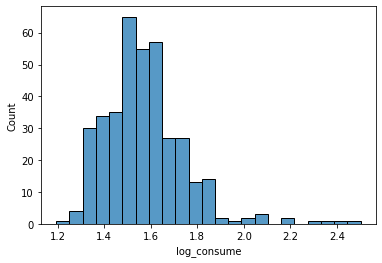

In [25]:
sns.histplot(consume_data.log_consume);

In [26]:
scaler = StandardScaler()

In [39]:
consume_data_scaled=pd.DataFrame(scaler.fit_transform(consume_data), columns=consume_data.columns)

In [28]:
linear_model_2 = smf.ols("log_consume ~ speed  + temp_outside + AC + rain + sun + snow + gas_type_SP98", data=consume_data).fit()

In [29]:
linear_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_consume   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     15.62
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           6.11e-18
Time:                        20:45:18   Log-Likelihood:                 163.29
No. Observations:                 376   AIC:                            -310.6
Df Residuals:                     368   BIC:                            -279.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.7727      0.032     56.115      0.000       1.711       1.835
speed            -0.0026      0.001     -4.271      0.000      -0.004      -0.001
temp_outside     -0.0085      0.001     -6.511      0.000      -0.011      -0.006
AC                0.0664      0.032      2.101      0.036       0.004       0.128
rain              0.0958      0.027      3.500      0.001       0.042       0.150
sun              -0.0320      0.032     -1.005      0.316      -0.095       0.031
snow             -0.0436      0.084     -0.521      0.602      -0.208       0.121
gas_type_SP98    -0.0095      0.017     -0.563      0.574      -0.043       0.024
==============================================================================
Omnibus:                      111.195   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.740
Skew:                           1.317   Prob(JB):                     2.31e-80
Kurtosis:                       7.059   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- This time we can see that we got a R2 of 0.229, a slightly improvement,   
- We can see from the p-values that `sun`, `snow` and `gas_type` are still non-significant.

#### From the regression analisis, we can say that the variables whic are significant to predict the mean of consumption are `rain`, `AC`, `temp_outside`  and `speed`. Which goes in line with the correlation analysis.

### CONSUME COST

- We'll enrich the data with the price of the gas

In [30]:
def price(x):
    E10_price = 1.379
    SP98_price = 1.459
    if x == 0:
        return E10_price
    else:
        return SP98_price

In [31]:
consume_data['price'] = consume_data.gas_type_SP98.apply(price)

In [32]:
consume_data['cost_per_distance'] =(((consume_data.consume)/100) * (consume_data.distance)) * consume_data.price 

In [40]:
price_gr = consume_data.groupby('gas_type_SP98').agg({'cost_per_distance': 'mean'})
price_gr

,cost_per_distance
gas_type_SP98,
0,1.396125
1,1.305041


- From the above data frame we can see that the cars with ethanol gas-type, have a higher cost consumption, even if the price of ethanol is lower.